In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)


from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from tools import get_tools_output
from agents import(
    AgentState,
    agents,
    agent_name
)
from tools import all_tools
from chat_history import save_chat_history, load_chat_history

## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(all_tools)


def analyst_router(state) -> Literal["call_tool", "__end__", "data_collector"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        return "__end__"
    if last_message.tool_calls:
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    else:
        return "continue"
    
    
def data_collector_router(state) -> Literal["call_tool", "reporter"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "reporter" in last_message.content:
        return "reporter"
    else:
        return "continue"
    
    
def reporter_router(state) -> Literal["call_tool", "data_collector"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        return "__end__"
    if last_message.tool_calls:
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    else:
        return "continue"


def router(state) -> Literal["call_tool", "__end__", "data_collector", "reporter", "analyst"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    if "reporter" in last_message.content:
        return "reporter"
    if "analyst" in last_message.content:
        return "analyst"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, value in agents.items():
    workflow.add_node(name, value['node'])
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    analyst_router,
    {
        "call_tool": "call_tool", 
        "data_collector":"data_collector",
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "data_collector",
    data_collector_router,
    {
        "call_tool": "call_tool", 
        "reporter":"reporter",
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    reporter_router,
    {
        "__end__": END,
        "data_collector":"data_collector",
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()


def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=18
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    graph = workflow.compile()

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            # print(e)
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER", "")
    
    if keep_chat_history:
        save_chat_history(bot_message=response, human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

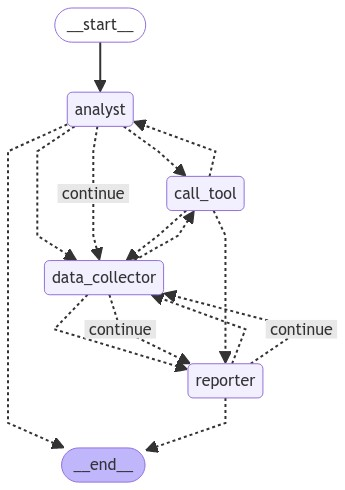

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
# import utils
result = submitUserMessage("วิเคราะห์ร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว", keep_chat_history=True, return_reference=True, verbose=True)
utils.notify(sound_effect="purr")

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  find_place_from_text (call_xjoelJvOTIGZVdQAtkIufcyC)
 Call ID: call_xjoelJvOTIGZVdQAtkIufcyC
  Args:
    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว
  find_place_from_text (call_QXN2ZD3mpXChFO7CXtvVg2rX)
 Call ID: call_QXN2ZD3mpXChFO7CXtvVg2rX
  Args:
    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว
================================= Tool Message =================================
Name: find_place_from_text


    address: 60 127 ซอย ลาดพร้าว 111 แขวงคลองจั่น เขตบางกะปิ กรุงเทพมหานคร 10240 ไทย

    location_name: ลุมพินี เซ็นเตอร์ ลาดพร้าว 111

    
================================== Ai Message ==================================
Name: analyst

I have identified the location and type of business for your feasibility analysis request. 

- **Location**: ลุมพินี เซ็นเตอร์ ลาดพร้าว
- **Keyword**: ร้านอาหารไทย (Thai restaurant)

I will now pass this information to the Data Collector for further analysi

In [4]:
submitUserMessage("ต้องการขายข้าวในราคา 300", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_kEfr3DmsliWuUROS1dmlMeNY)
 Call ID: call_kEfr3DmsliWuUROS1dmlMeNY
  Args:
    input_dict: {'base_price': 300, 'category': 'Rice Bowl'}
================================= Tool Message =================================
Name: restaurant_sale_projection

sale projection of Rice Bowl:
week	number of order	sale(forecast)
1	635	190,620
5	2,335	700,410
52	686	205,740

================================== Ai Message ==================================
Name: analyst

FINALANSWER

การขายข้าวในราคา 300 บาทนั้นสามารถคาดการณ์ยอดขายได้ดังนี้:

- **สัปดาห์ที่ 1**: จำนวนการสั่งซื้อ 635 รายการ, ยอดขายประมาณ 190,620 บาท
- **สัปดาห์ที่ 5**: จำนวนการสั่งซื้อ 2,335 รายการ, ยอดขายประมาณ 700,410 บาท
- **ปีที่ 1 (52 สัปดาห์)**: จำนวนการสั่งซื้อ 686 รายการ, ยอดขายประมาณ 205,740 บาท

### การวิเคราะห์ราคา
- **ราคา 300 บาท**: เป็นราคาที่สูงกว่าคู่แข่งในตลาดอาหารไทย ซึ่งอาจทำให้ก

('\n\nการขายข้าวในราคา 300 บาทนั้นสามารถคาดการณ์ยอดขายได้ดังนี้:\n\n- **สัปดาห์ที่ 1**: จำนวนการสั่งซื้อ 635 รายการ, ยอดขายประมาณ 190,620 บาท\n- **สัปดาห์ที่ 5**: จำนวนการสั่งซื้อ 2,335 รายการ, ยอดขายประมาณ 700,410 บาท\n- **ปีที่ 1 (52 สัปดาห์)**: จำนวนการสั่งซื้อ 686 รายการ, ยอดขายประมาณ 205,740 บาท\n\n### การวิเคราะห์ราคา\n- **ราคา 300 บาท**: เป็นราคาที่สูงกว่าคู่แข่งในตลาดอาหารไทย ซึ่งอาจทำให้การขายยากขึ้นหากไม่มีคุณภาพหรือบริการที่โดดเด่น\n- **ข้อเสนอแนะ**: ควรพิจารณาเปรียบเทียบราคากับคู่แข่งในพื้นที่เพื่อให้สามารถแข่งขันได้อย่างมีประสิทธิภาพ\n\nหากต้องการข้อมูลเพิ่มเติมหรือการวิเคราะห์ในด้านอื่น ๆ กรุณาแจ้งให้ทราบ!',
 'sale projection of Rice Bowl:\nweek\tnumber of order\tsale(forecast)\n1\t635\t190,620\n5\t2,335\t700,410\n52\t686\t205,740\n\n')

In [5]:
submitUserMessage("if i it passible to sell rice 10 bath each.", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_4dQnq2Zox6XBNeex5o0YMC0D)
 Call ID: call_4dQnq2Zox6XBNeex5o0YMC0D
  Args:
    input_dict: {'base_price': 10, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_KyfyPrrJioyEJs8qcbYYn73W)
 Call ID: call_KyfyPrrJioyEJs8qcbYYn73W
  Args:
    input_dict: {'base_price': 300, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_87cCGIgM16OGU1D5iUMko3AE)
 Call ID: call_87cCGIgM16OGU1D5iUMko3AE
  Args:
    input_dict: {'base_price': 50, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_2l2frPdQg3MS8DbHud91NKAU)
 Call ID: call_2l2frPdQg3MS8DbHud91NKAU
  Args:
    input_dict: {'base_price': 100, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_KgvfnCSZe4cQOT2eybRZYpTz)
 Call ID: call_KgvfnCSZe4cQOT2eybRZYpTz
  Args:
    input_dict: {'base_price': 150, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_RnrSLS7FYC

('\n### การวิเคราะห์ความเป็นไปได้ของร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว\n\n#### 1. สรุป\n- **ภาพรวมโดยย่อ**: รายงานนี้วิเคราะห์ความเป็นไปได้ของการเปิดร้านอาหารไทยในพื้นที่ลุมพินี เซ็นเตอร์ ลาดพร้าว โดยมีการสำรวจตลาด คู่แข่ง และความต้องการของลูกค้า\n- **ข้อสรุปความเป็นไปได้**: การเปิดร้านอาหารไทยในพื้นที่นี้มีศักยภาพสูง เนื่องจากมีประชากรหนาแน่นและคู่แข่งที่มีคุณภาพ\n\n#### 2. แนวคิดธุรกิจ\n- **คำอธิบายผลิตภัณฑ์/บริการ**: ร้านอาหารไทยที่ให้บริการอาหารไทยต้นตำรับ\n- **จุดขายที่ไม่เหมือนใคร (USP)**: การใช้วัตถุดิบสดใหม่และสูตรอาหารที่เป็นเอกลักษณ์\n- **ความต้องการของลูกค้า**: ลูกค้าต้องการอาหารไทยที่มีรสชาติอร่อยและบริการที่ดี\n\n#### 3. การวิเคราะห์การแข่งขัน\n- **ภูมิทัศน์การแข่งขัน**: มีร้านอาหารไทย 5 แห่งในพื้นที่ที่มีคะแนนรีวิวตั้งแต่ 4.5 ถึง 5.0\n- **รายการเปรียบเทียบคู่แข่ง**:\n  - **The Original**: ราคา 1,600-2,400 บาทสำหรับ 2 คน, คะแนน 4.6\n  - **ตำอุดร Tam Udon E-San Cuisine**: ราคาไม่พบ, คะแนน 5.0\n  - **Thai Flavours**: ราคาไม่พบ, คะแนน 5.0\n  - **Thai Restaurant**: ราคา